<a href="https://colab.research.google.com/github/Davis-wj/MyPapers/blob/master/plant_disease_detection_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#数据分析

##载入相关库和数据

###载入Google云盘，并改变工作目录

In [3]:
# 载入Google drive
from google.colab import drive
drive.mount('/content/drive')

!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [4]:
# 改变工作路径
import os

path = "/content/drive/My Drive/DataSet/Plant"
os.chdir(path)
os.listdir(path)
!ls

all_images_dir	label_transform.pkl			   PlantVillage
base_dir	my_model.h5				   模型
cnn_model.pkl	plant-disease-detection-using-keras.ipynb  病害数据分析.ipynb


###载入必要的库

In [5]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  #习惯上简写成snssns.set()           
#sns.set()#切换到seaborn的默认运行配置


Using TensorFlow backend.


###设置模型训练相关的超参
这里的参数是经过训练调节好的

In [0]:
EPOCHS = 28
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './PlantVillage'
width=256
height=256
depth=3

In [7]:
!ls ./PlantVillage

PlantVillage


###查看每个文件夹有多少张图片
####从下面分析该数据集的分布是很不均衡的，这并不是我们想要看到的。所以避免结构化风险和过拟合，我们需要对数据进行划分，使数据集各个类别相对的平衡起来

每种目录对应的文件数量为：
Pepper__bell___healthy: 1478
Tomato_Late_blight: 1909
Pepper__bell___Bacterial_spot: 997
Potato___healthy: 152
Potato___Late_blight: 1000
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_Leaf_Mold: 952
Tomato_healthy: 1591
Potato___Early_blight: 1000
Tomato_Septoria_leaf_spot: 1771
Tomato__Tomato_mosaic_virus: 373
Tomato__Tomato_YellowLeaf__Curl_Virus: 3210
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404


图像总数:  20640


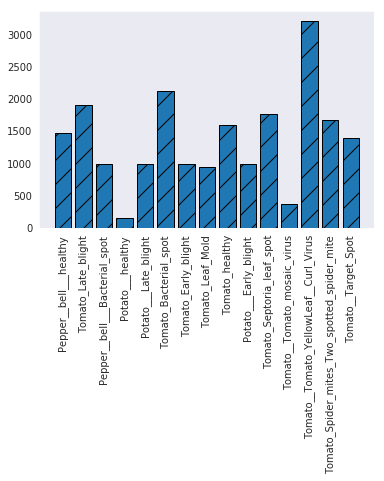

In [37]:
# 查看多多少个文件
folder_list = os.listdir('./PlantVillage/PlantVillage/')

total_images = 0
data = [] # 存储文件数量的数据
labels = [] # 存储标签
# loop through each folder
print("每种目录对应的文件数量为：")
for folder in folder_list:
    # set the path to a folder
    path = './PlantVillage/PlantVillage/' + str(folder)
    # get a list of images in that folder
    images_list = os.listdir(path)
    # get the length of the list
    num_images = len(images_list)
    
    total_images = total_images + num_images
    # print the result
    print(str(folder) + ':' + ' ' + str(num_images))
    data.append(num_images)
    labels.append(folder)
    


plt.bar(range(len(data)), data, ec='k', lw=1, hatch='/', tick_label=labels)
plt.xticks(rotation=90)
plt.show
print('\n')
# print the total number of images available
print('图像总数: ', total_images)

####从下图更可以看出数据严重的不均衡

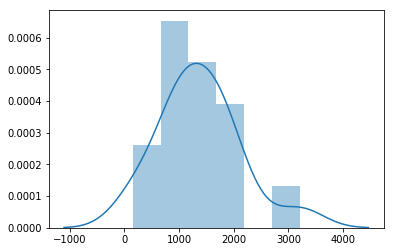

In [9]:
sns.distplot(data)

###查看每种疾病的类别

In [0]:
all_images_dir = 'all_images_dir'

In [34]:
# 检查是否成功创建 all_image_dir
!ls

all_images_dir	label_transform.pkl			   PlantVillage
base_dir	my_model.h5				   模型
cnn_model.pkl	plant-disease-detection-using-keras.ipynb  病害数据分析.ipynb


In [39]:
# 检查是否文件总数与上方的统计的相同
if total_images == len(os.listdir('./all_images_dir')):
  print("all_images_dir文件与目标文件数量相同")
  print("图片总数量为：{}".format(total_images))
else:
  print("all_images_dir数量与模板文件数量不符合！请检查错误！")

all_images_dir文件与目标文件数量相同
图片总数量为：20640


###获取文件列表，再下一步中对文件列表添加标签方便对数据进行进一步的分析

In [42]:
# 获取all_images_dir文件夹中所有图像的列表。
import pandas as pd
image_list = os.listdir('./all_images_dir')

# 创建数据框。
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,Tomato__Target_Spot*9719a548-125a-449c-8f7b-01...
1,Tomato__Target_Spot*97aef801-dfae-4670-b148-3a...
2,Tomato__Target_Spot*970f236d-e002-4393-b65d-f7...
3,Tomato__Target_Spot*994414de-c6a6-4d55-8a61-eb...
4,Tomato__Target_Spot*9965b863-cf76-4d26-91a4-96...


In [44]:
# 此函数将从每个图像的文件名中提取类别名。
def extract_target(x):
    # 分成一个列表
    a = x.split('*')
    # target 是列表的第一个索引
    target = a[0]
    
    return target


# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

,image_id,target
0,Tomato__Target_Spot*9719a548-125a-449c-8f7b-01...,Tomato__Target_Spot
1,Tomato__Target_Spot*97aef801-dfae-4670-b148-3a...,Tomato__Target_Spot
2,Tomato__Target_Spot*970f236d-e002-4393-b65d-f7...,Tomato__Target_Spot
3,Tomato__Target_Spot*994414de-c6a6-4d55-8a61-eb...,Tomato__Target_Spot
4,Tomato__Target_Spot*9965b863-cf76-4d26-91a4-96...,Tomato__Target_Spot


In [45]:
df_data.shape # 检测数据是否正确，可以看出没有问题

(20640, 2)

In [0]:
sns.set_style("dark") # seaborn默认格式是开启网格的所以此处需要关闭
# 代码来源: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

###分析数据
从下方每种类别植物对应的图片可以看出，在Pepper_bell_healthy健康的叶片与其他Pepper bell的疾病肉眼去区分差别不大。


在Tomato植物疾病中可以观察到，Tomato_Target_spot疾病与Tomato健康的叶片差别不大。


这样也会导致后面的模型训练产生误差，这样下下方**模型训练**与**混淆矩阵体**现出来。

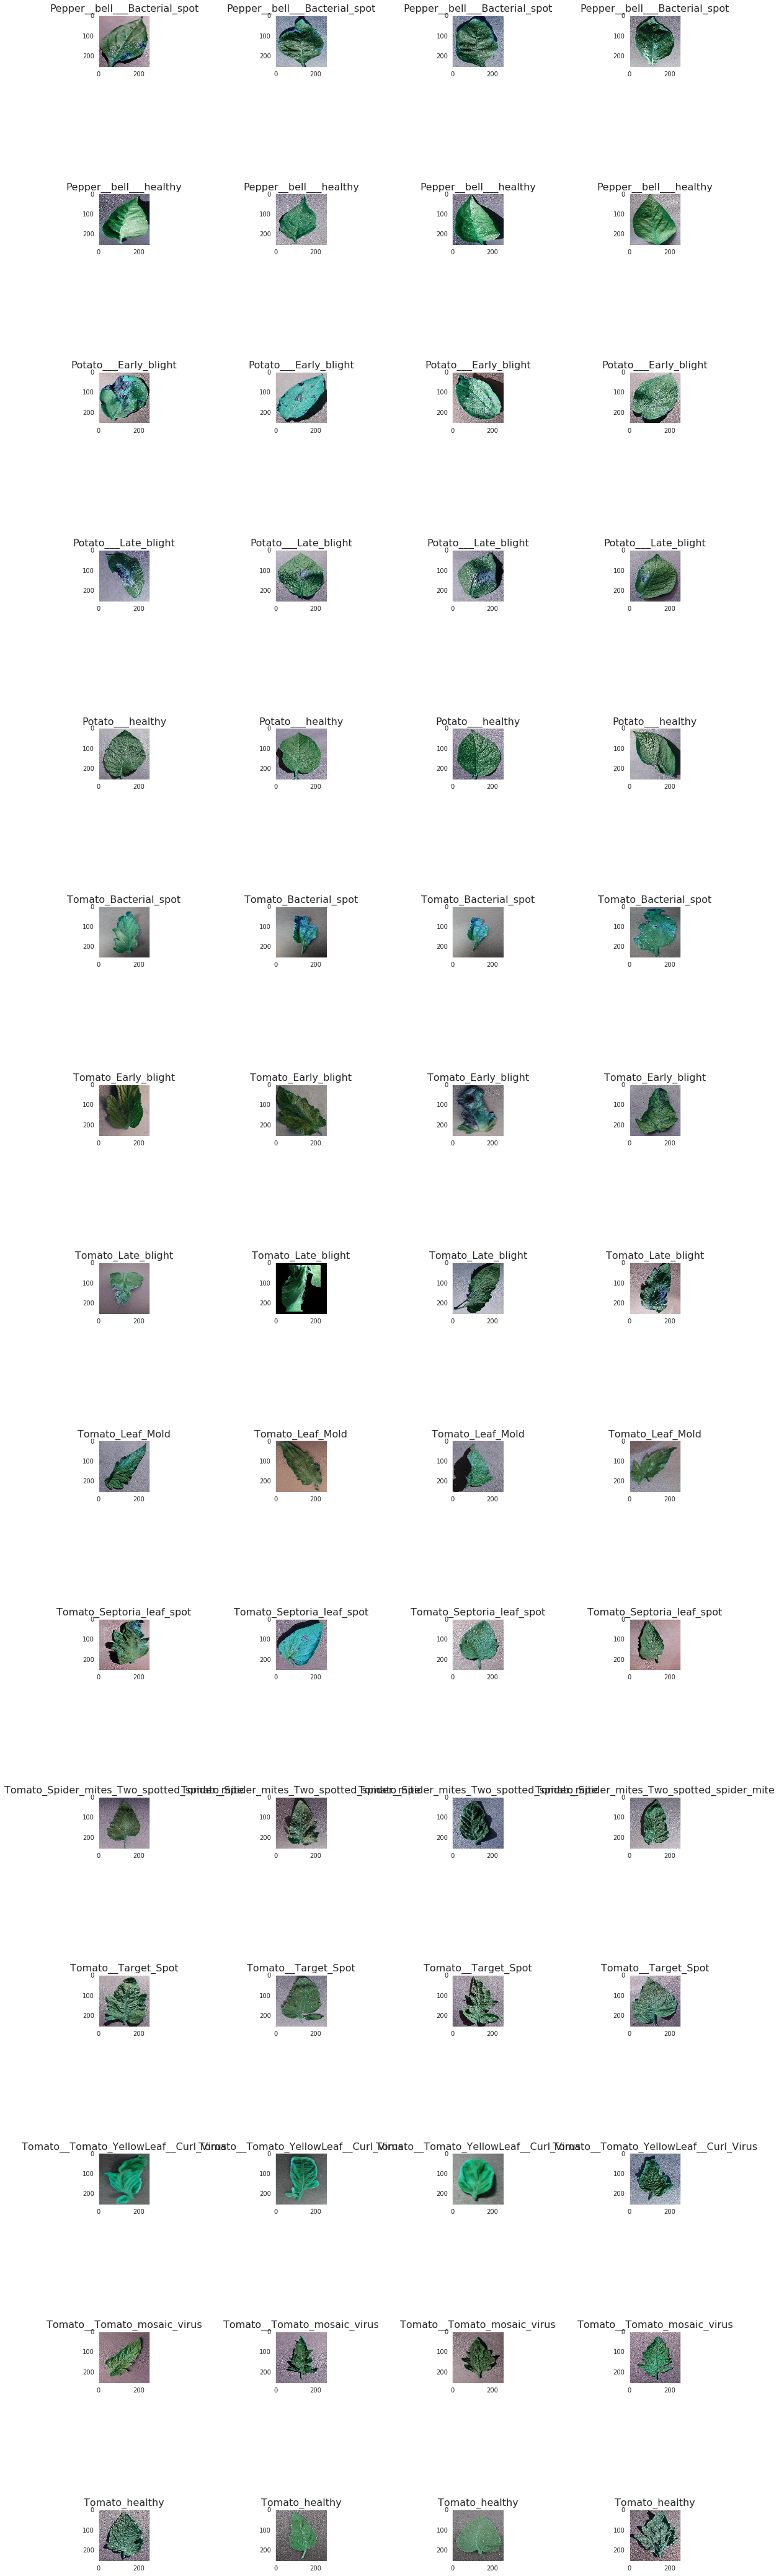

In [48]:
IMAGE_PATH = './all_images_dir/'

draw_category_images('target',4, df_data, IMAGE_PATH)

##对数据集进行平衡分割

###该函数将图像转换为数组
转换成数组后便于对数据进行分割

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

###从目录中获取图像  
####由上面的数据分析可以知道Potato___healthy类别的图像只有152个，为了尽可能的平衡数据，我们把每个类别分割为200个数据，下面代码完成了该任务。


In [11]:
image_list, label_list = [], []
try:
    print("[INFO] 载入图片 ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # 由于文件不知有图片还存在.DS_Store文件，会导致后面出现错误
        # 现在对该文件进行过滤
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # 由于文件不知有图片还存在.DS_Store文件，会导致后面出现错误
            # 现在对该文件进行过滤
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] 正在处理 {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] 图片载入完成")  
except Exception as e:
    print(f"Error : {e}")

[INFO] 载入图片 ...
[INFO] 正在处理 Pepper__bell___healthy ...
[INFO] 正在处理 Tomato_Late_blight ...
[INFO] 正在处理 Pepper__bell___Bacterial_spot ...
[INFO] 正在处理 Potato___healthy ...
[INFO] 正在处理 Potato___Late_blight ...
[INFO] 正在处理 Tomato_Bacterial_spot ...
[INFO] 正在处理 Tomato_Early_blight ...
[INFO] 正在处理 Tomato_Leaf_Mold ...
[INFO] 正在处理 Tomato_healthy ...
[INFO] 正在处理 Potato___Early_blight ...
[INFO] 正在处理 Tomato_Septoria_leaf_spot ...
[INFO] 正在处理 Tomato__Tomato_mosaic_virus ...
[INFO] 正在处理 Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] 正在处理 Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] 正在处理 Tomato__Target_Spot ...
[INFO] 图片载入完成


###获取已处理图像的大小

In [0]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [14]:
print("查看标签列表：",label_list)
print("图片的数量为：",image_size)
print("图像类别数量为：",n_classes)

查看标签列表： ['Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Pe

###打印类别

In [15]:
print("该数据集类别为:","\n",label_binarizer.classes_)

该数据集类别为: 
 ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

#模型训练

##数据集的划分与处理

###数据集的划分

In [17]:
print("[INFO] 拆分数据进行训练，测试")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] 拆分数据进行训练，测试


###图片的预处理

In [0]:
aug = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

##模型的设置与训练

###设置模型结构



In [19]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


###模型摘要

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

###优化器的设置

In [21]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


##对模型进行训练
###由于该过程较为缓慢，前面已经训练好模型了。所以下面该步骤进行跳过，直接读取训练好的模型进行预测


In [22]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/28
73/73 [==============================] - 37s 511ms/step - loss: 0.2230 - acc: 0.9309 - val_loss: 0.5762 - val_acc: 0.9025
Epoch 2/28
73/73 [==============================] - 30s 414ms/step - loss: 0.1622 - acc: 0.9442 - val_loss: 0.6470 - val_acc: 0.9059
Epoch 3/28
73/73 [==============================] - 32s 433ms/step - loss: 0.1158 - acc: 0.9584 - val_loss: 0.2153 - val_acc: 0.9439
Epoch 4/28
73/73 [==============================] - 31s 424ms/step - loss: 0.1456 - acc: 0.9512 - val_loss: 1.0049 - val_acc: 0.8895
Epoch 5/28
73/73 [==============================] - 30s 415ms/step - loss: 0.1441 - acc: 0.9507 - val_loss: 0.7852 - val_acc: 0.8992
Epoch 6/28
73/73 [==============================] - 31s 428ms/step - loss: 0.1120 - acc: 0.9590 - val_loss: 0.4313 - val_acc: 0.9267
Epoch 7/28
73/73 [==============================] - 30s 414ms/step - loss: 0.1042 - acc: 0.9633 - val_loss: 0.2323 - val_acc: 0.9461
Epoch 8/28
73/73 [===

##绘制train集与val集曲线

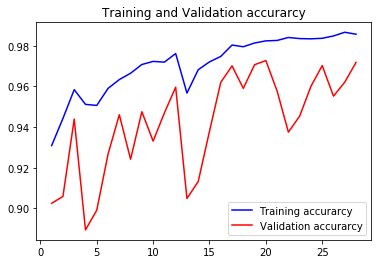

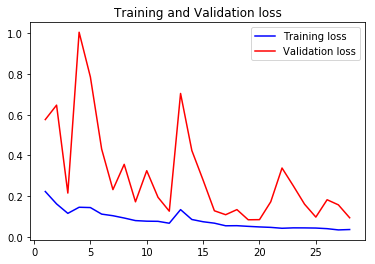

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##读取训练好的模型

In [0]:
# # 由于训练过了直接读取
from keras.models import load_model
model = load_model('my_model.h5')

###测试模型准确性

In [49]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"测试准确度: {scores[1]*100}","%")

[INFO] Calculating model accuracy
591/591 [==============================] - 2s 3ms/step
测试准确度: 97.17992319270036 %


##保存模型

In [0]:
# 将模型保存到磁盘
# 该方法保存pkl格式，后来说这种格式并不是很好，所以弃用，改用下方的模型格式进行保存
#print("[INFO] 保存模型中...")
#pickle.dump(model,open('cnn_model.pkl', 'wb'))

In [0]:

from keras.models import load_model
 
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model
 
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

#模型效果可视化

###尝试画出混淆矩阵

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test2,y_pred)
print(cm)

[[34 18  0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0 45  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  2  1  0  0  0  0  0  0]
 [ 0  3  1 32  4  0  1  2  0  0  0  0  0  0  0]
 [ 0  4  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  3  0  0  0  0  3  0  0]
 [ 0  1  1  0  0  1 33  1  1  0  0  0  2  0  1]
 [ 2  2  0  1  0  0  4 30  0  0  0  0  0  0  1]
 [ 1  3  0  0  0  0  0  4 36  0  0  0  2  1  0]
 [ 0  3  3  0  0  0  0  0  7 20  0  0  0  0  0]
 [ 1  1  0  0  1  0  2  0  0  0 22  0  6  1  5]
 [ 0  4  0  0  2  0  2  0  0  0  1 10  1  1 11]
 [ 0  1  0  0  0  2  0  0  1  0  0  0 47  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 35]]


####下面代码摘自 [该处](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
请不要使用中文，因为matplot对中文支持并不是很好

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix8

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

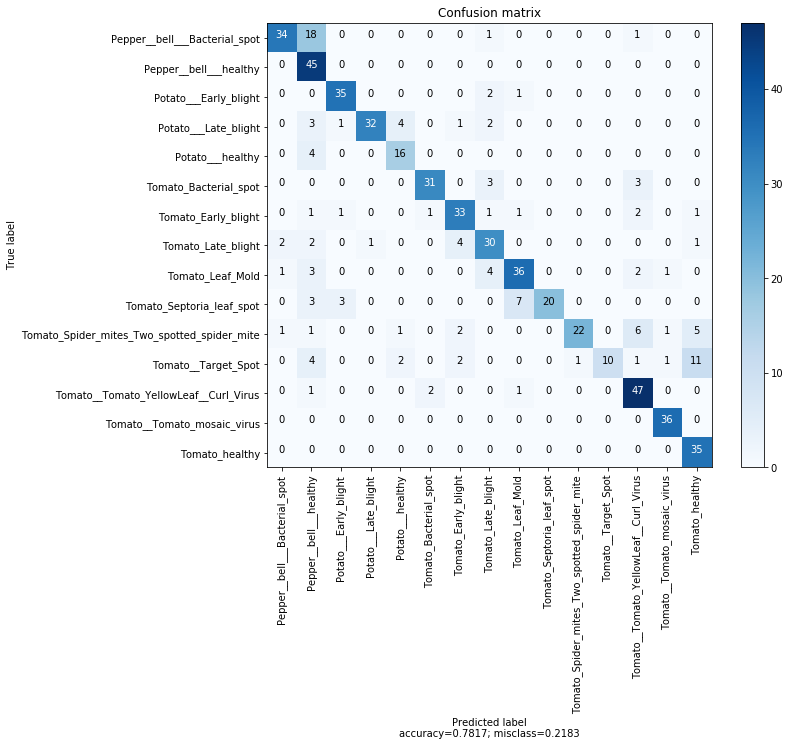

In [30]:
plot_confusion_matrix(cm=cm, 
                      normalize    = False,
                      target_names = label_binarizer.classes_,
                      title        = "Confusion matrix")